In [1]:
import re
import pandas as pd
import numpy as np
from pprint import pprint
import spacy
from nltk.stem import WordNetLemmatizer
import nltk; nltk.download('stopwords')
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
# %matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /Users/jihok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
july_data = pd.read_csv("SNOW July Data.csv", encoding = "ISO-8859-1")

In [3]:
# INDIVIDUAL DATASET TESTING/OBSERVATION
# currently selects descriptions manually. This will later be transitioned to a for-loop or some function
# look at july_data to see which index value you want to see tested
july_data = july_data.loc[(july_data['contact'] != 'SPAM SPAM') & (july_data['resolution_code'] != 'Spam')].reset_index(drop=True)
july_samp = july_data.iloc[234]['description']

# DESCRIPTION CLEANING
regex_sol = re.sub(r'https?://\S+', '', july_samp) # removes URL links
regex_sol = re.sub(r"\S*@\S*\s?", "", regex_sol) # removes email accounts
regex_sol = regex_sol.replace("\n", "").replace("< >","").replace("\r", "") # removes newline and <> and \r
regex_sol = re.sub(r"\d+", "", regex_sol) # removes integers 
regex_sol = re.sub(r"([^\s\w]|_)+", " ", regex_sol) # removes non-alphanumeric characters, but maintains whitespace
regex_sol = regex_sol.encode("ASCII", "replace").decode("utf-8").replace("?", " ") # removes all non-ASCII characters
regex_sol = regex_sol.lower()
# regex_sol

# SUBJECT LINE CLEANING
july_samp_2 = july_data.iloc[7]['case']
regex_sol_2 = re.sub(r"[?](CS)[0-9]+", "", july_samp_2)
regex_sol_2 = re.sub(r"\d+", "", regex_sol_2)
regex_sol_2 = re.sub(r"([^\s\w]|_)+", " ", regex_sol_2)
regex_sol_2 = regex_sol_2.lower()
# regex_sol_2

In [4]:
# FUNCTIONS APPLY CURRENT CLEANING STEPS INTO ENTIRE DATASET

def subject_clean(subject_line):
    regex_sol = re.sub(r'https?://\S+', '', subject_line) # removes URL links
    regex_sol = re.sub(r"\S*@\S*\s?", "", regex_sol) # removes email accounts
    regex_sol = regex_sol.replace("\n", "").replace("< >","").replace("\r", "") # removes newline and <> and \r
    regex_sol = re.sub(r"\d+", "", regex_sol) # removes integers 
    regex_sol = re.sub(r"([^\s\w]|_)+", " ", regex_sol) # removes non-alphanumeric characters, but maintains whitespace
    regex_sol = regex_sol.encode("ASCII", "replace").decode("utf-8").replace("?", " ") # removes all non-ASCII characters
    regex_sol = regex_sol.lower() # lower case string
    return regex_sol

def case_line_clean(case_line):
    regex_sol_2 = re.sub(r"[?](CS)[0-9]+", "", case_line) # removes ending "?CS###"
    regex_sol_2 = re.sub(r"\d+", "", regex_sol_2) # removes integers
    regex_sol_2 = re.sub(r"([^\s\w]|_)+", " ", regex_sol_2) # removes non-characters, but maintains whitespace
    regex_sol_2 = regex_sol_2.lower()
    return regex_sol_2

# call the dataset that pertains to you
# june_dataset = pd.read_csv("SNOW June Data.csv", encoding = "ISO-8859-1")
# july_dataset = pd.read_csv("SNOW July Data.csv", encoding = "ISO-8859-1")
august_dataset = pd.read_csv("SNOW August Data.csv", encoding = "ISO-8859-1")
september_dataset = pd.read_csv("SNOW September Data.csv", encoding = "ISO-8859-1")

#SPAM case removal
# june_dataset = june_dataset.loc[(june_dataset['contact'] != 'SPAM SPAM') & (june_dataset['resolution_code'] != 'Spam')].reset_index(drop=True)
# july_dataset = july_dataset.loc[(july_dataset['contact'] != 'SPAM SPAM') & (july_dataset['resolution_code'] != 'Spam')].reset_index(drop=True)
august_dataset = august_dataset.loc[(august_dataset['contact'] != 'SPAM SPAM') & (august_dataset['resolution_code'] != 'Spam')].reset_index(drop=True)
september_dataset = september_dataset.loc[(september_dataset['contact'] != 'SPAM SPAM') & (september_dataset['resolution_code'] != 'Spam')].reset_index(drop=True)

# Regex cleaning applied to both the "description" and "case" columns in each dataset
# june_dataset['description'] = june_dataset['description'].apply(subject_clean)
# july_dataset['description'] = july_dataset['description'].apply(subject_clean)
august_dataset['description'] = august_dataset['description'].apply(subject_clean)
september_dataset['description'] = september_dataset['description'].apply(subject_clean)

# june_dataset['case'] = june_dataset['case'].apply(case_line_clean)
# july_dataset['case'] = july_dataset['case'].apply(case_line_clean)
august_dataset['case'] = august_dataset['case'].apply(case_line_clean)
september_dataset['case'] = september_dataset['case'].apply(case_line_clean)

# Concat the cleaned data into one dataframe for use


In [5]:
# June annd July have been removed 
all_months = pd.concat([august_dataset, september_dataset]).reset_index()
all_months

,index,case,contact,description,short_description,business_service,service_offering,resolution_code
0,0,covid related your grainger order po ...,Grainger Grainger,received from hello access to covid related...,(Covid Related) Your Grainger Order # 1387551...,Oracle Procurement,Supplier Request for Account Information,Inconclusive - No Customer Response
1,1,funds check has warnings error,Janelle Fine,hello when i place orders on project oracl...,"""Funds check has warnings"" error",Oracle Procurement,Other Buying Inquiry,Inconclusive - No Customer Response
2,2,p,Alan Garcia Calixto,hello the student listed on the subject line h...,00539230P,Payee Profile Setup,Payee Setup/Update Questions,NaN
3,3,cant complete po charge account fails look up,Johnny Nguyen,i have been having an issue with processing a ...,8/5/2020 - Cant complete PO Charge account fai...,Oracle Procurement,Other Buying Inquiry,Inconclusive - No Customer Response
4,4,abcam order ref order shipping confirmation...,Orders Abcam,received from cce ref customer number dea...,Abcam order (ref:ORDER #3879476) shipping conf...,Oracle Procurement,Other Buying Inquiry,Inconclusive - No Customer Response
...,...,...,...,...,...,...,...,...
1492,511,your opinion counts,Jamie Wheat,received from your contact details nbsp namej...,Your Opinion Counts! [#15440],Office Administration,IPPS Office Admin,Don't Send Notifications
1493,512,action required vector laboratories price ap...,Vector Labs CS,received from good day there is a price discr...,[ACTION REQUIRED] Vector Laboratories Price Ap...,Oracle Procurement,Supplier Request for Account Information,NaN
1494,513,cycling support update invitation to uc s...,Sales Cycling74,received from please type your reply above ...,[Cycling '74 Support] Update: Invitation to UC...,Payment Compass,Payment Compass Access,Inconclusive - No Customer Response
1495,514,graphpad re document purchase order pur,NaN,received from please type your reply above ...,[GraphPad] Re: Document Purchase Order PUR0003...,Oracle Procurement,Other Buying Inquiry,NaN


In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
domain_stop_words = ['hi', 'hello', 'thank', 'thanks', 'com', 'the', 're', 'php', 'http', 'XXXXXXXXX', 'would', 'however', 'please', 'do', 'can', 'may', 'check', 'pende', 'tell', 'use', 'call', 'let', 'dear', 'see', 'click', 'still', 'unable', 'even', 'minute', 'basically', 'seem', 'expect', 'pcie', 'usd', 'go', 'could', 'advise', 'appreciate', 'regard', 'also', 'end', 'sure', 'copy', 'phone', 'know', 'accidently', 'reply', 'web', 'soon', 'regard', 'get', 'try', 'new', 'follow', 'date', 'pm' ,'back', 'note', 'u', 'sincerely', 'immediately', 'notify', 'one', 'two', 'someone', 'day', 'put', 'start', 'set', 'reply', 'advise', 'august', 'arise', 'therewith', 'regarding', 'san', 'diego', 'uc', 'inc', 'ca', 'go', 'able', 'say', 'like', 'wav_file', 'ref', 'monday']
# unable, seem
stop_words.extend(domain_stop_words)
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


In [8]:
# julydescrip = list(july_dataset['description'])
alldescrip = list(all_months['description'])

In [9]:
# data_words = list(sent_to_words(julydescrip))
data_words = list(sent_to_words(alldescrip))

In [10]:
print(data_words[:1])

[['received', 'from', 'hello', 'access', 'to', 'covid', 'related', 'products', 'has', 'been', 'challenging', 'due', 'to', 'high', 'global', 'demand', 'and', 'limited', 'available', 'supply', 'grainger', 'has', 'been', 'working', 'closely', 'with', 'current', 'and', 'new', 'suppliers', 'to', 'obtain', 'product', 'or', 'find', 'alternatives', 'in', 'response', 'to', 'the', 'ongoing', 'pandemic', 'to', 'that', 'end', 'grainger', 'is', 'excited', 'to', 'offer', 'more', 'readily', 'available', 'alternate', 'for', 'your', 'open', 'backorder', 'please', 'see', 'your', 'order', 'details', 'and', 'options', 'below', 'and', 'reply', 'to', 'this', 'email', 'indicating', 'any', 'desired', 'actions', 'you', 'would', 'like', 'for', 'us', 'to', 'take', 'if', 'interested', 'and', 'your', 'backorder', 'is', 'still', 'open', 'please', 'reply', 'to', 'this', 'email', 'as', 'soon', 'as', 'possible', 'as', 'pandemic', 'related', 'alternate', 'items', 'are', 'in', 'high', 'demand', 'please', 'note', 'that',

In [11]:
#initiate blank list
text_words = []

#for loop to tokenize all words in
# for sentence in julydescrip:
#     temp = gensim.utils.simple_preprocess(sentence)
#     text_words.append(temp)

for sentence in alldescrip:
    temp = gensim.utils.simple_preprocess(sentence)
    text_words.append(temp)

In [12]:
# Build the bigram
bigram = gensim.models.Phrases(text_words, min_count=5, threshold=100)

In [13]:
#Removeal of stop words
text_words_no_stops = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text_words]

#Make texts into bigram model
text_words_no_stops_bigram = [bigram[doc] for doc in text_words_no_stops]

In [14]:
text_words_no_stops_bigram[0]

['received',
 'access',
 'covid',
 'related',
 'products',
 'challenging',
 'due',
 'high',
 'global',
 'demand',
 'limited',
 'available',
 'supply',
 'grainger',
 'working',
 'closely',
 'current',
 'suppliers',
 'obtain',
 'product',
 'find',
 'alternatives',
 'response',
 'ongoing',
 'pandemic',
 'grainger',
 'excited',
 'offer',
 'readily',
 'available',
 'alternate',
 'open',
 'backorder',
 'order',
 'details',
 'options',
 'email',
 'indicating',
 'desired',
 'actions',
 'us',
 'take',
 'interested',
 'backorder',
 'open',
 'email',
 'possible',
 'pandemic',
 'related',
 'alternate',
 'items',
 'high',
 'demand',
 'due',
 'increased',
 'costs',
 'manufacture',
 'acquire',
 'transport',
 'items',
 'alternative',
 'product',
 'reflect',
 'higher',
 'prices',
 'backordered',
 'product',
 'customer',
 'ucsd',
 'eprocurement',
 'disbursements',
 'account',
 'contact',
 'name',
 'order',
 'backorder',
 'actions',
 'available',
 'keep',
 'backordered',
 'item',
 'open',
 'action',
 're

In [15]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#lemmatizer.lemmatize('rocks')

In [16]:
# word_list= text_words_no_stops_bigram[0]
# w2 = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
# w2

In [17]:
"""
for cases in text_words_no_stops_bigarm:
    for words in cases:
        print(words)
        print ("{0:20}{1:20}".format(words,lemmatizer.lemmatize(words, pos="n")))
"""

'\nfor cases in text_words_no_stops_bigarm:\n    for words in cases:\n        print(words)\n        print ("{0:20}{1:20}".format(words,lemmatizer.lemmatize(words, pos="n")))\n'

In [18]:
# Lemmatize with POS Tag
from nltk.corpus import wordnet

# return POS tag for next function
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [19]:
# Lemmatizing function 
# takes in full list of descriptions with stop words removed
# returns descriptions lemmatized
def lemm(text_stop_no_bigram):
    count = 0
    out = []
    for descrip in text_stop_no_bigram:
        count += 1
        inner = []
        for word in descrip:
            pos = get_wordnet_pos(word)
            inner.append(lemmatizer.lemmatize(word, pos))
        out.append(inner)
    return out


In [20]:
# Lemmatizes 
nltk.download('wordnet')
lemmed = (lemm(text_words_no_stops_bigram))
# data_lemmatized = lemmed
#lemmed[0]

[nltk_data] Downloading package wordnet to /Users/jihok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
#test = [['have', 'runs', 'what', 'oracle', 'requisitioning']]
#lemm(test)

In [22]:
#text_words_no_stops_bigram[0]

In [23]:
"""
#Function for lemmatization due to many steps
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
"""

'\n#Function for lemmatization due to many steps\ndef lemmatization(texts, allowed_postags=[\'NOUN\', \'ADJ\', \'VERB\', \'ADV\']):\n    texts_out = []\n    for sent in texts:\n        doc = nlp(" ".join(sent)) \n        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])\n    return texts_out\n'

In [24]:
#getting spacy 'en' and lemmetizing bi-grams
# nlp = spacy.load('en', disable=['parser', 'ner'])
# data_lemmatized = lemmatization(text_words_no_stops_bigram, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [25]:
#print(data_lemmatized[0])

In [26]:
#Create Dictionary
id2word = gensim.corpora.Dictionary(lemmed)

#Create Corpus
texts = lemmed

#Build TDF
corpus = [id2word.doc2bow(text) for text in texts]

# corpus[:1]

In [27]:
#Read Corups/TDF per case
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]


  ('message', 1),
  ('team', 1),
  ('today', 1),
  ('choose', 1),
  ('small', 2),
  ('receipt', 1),
  ('attachment', 1),
  ('confidential', 1),
  ('destroy', 1),
  ('intended_recipient', 1),
  ('proprietary', 1),
  ('sender', 1),
  ('unit', 1),
  ('register', 1),
  ('operation', 1),
  ('www', 1),
  ('llc', 1),
  ('authorize', 1),
  ('description', 1),
  ('transmit', 1),
  ('aug', 3),
  ('research', 1),
  ('sale', 1),
  ('intend', 1),
  ('storage', 2),
  ('environment', 1),
  ('well', 2),
  ('disclosure', 1),
  ('transmission', 2),
  ('california', 1),
  ('university', 1),
  ('main', 1),
  ('clinical', 1),
  ('ea', 1),
  ('immediate', 1),
  ('scale', 1),
  ('concern', 1),
  ('reliance', 1),
  ('upon', 1),
  ('constitute', 1),
  ('hereby_notified', 1),
  ('strictly_prohibited', 1),
  ('read', 1),
  ('legally_privileged', 1),
  ('altman', 1),
  ('electronic', 3),
  ('md', 1),
  ('sensitive', 1),
  ('ups', 1),
  ('development', 1),
  ('reply', 1),
  ('temperature', 2),
  ('assay', 1),
  (

In [28]:
# Build LDA Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=33,
                                           alpha='auto',
                                           per_word_topics=True)



In [29]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"update" + 0.039*"address" + 0.021*"email" + 0.019*"locate" + '
  '0.018*"item" + 0.017*"ship" + 0.016*"wav_file" + 0.016*"sender_comments" + '
  '0.016*"order" + 0.016*"result"'),
 (1,
  '0.100*"po" + 0.038*"invoice" + 0.033*"sent" + 0.023*"vendor" + '
  '0.023*"payment" + 0.020*"pur" + 0.014*"pay" + 0.012*"forward" + '
  '0.009*"processing" + 0.009*"service"'),
 (2,
  '0.117*"message" + 0.057*"attachment" + 0.032*"error" + 0.029*"content" + '
  '0.025*"intended_recipient" + 0.025*"sender" + 0.023*"delete" + '
  '0.023*"transmission" + 0.023*"receive" + 0.021*"merck_kgaa"'),
 (3,
  '0.022*"well" + 0.011*"box" + 0.010*"hope" + 0.008*"available" + '
  '0.008*"group" + 0.008*"resolve" + 0.008*"mix" + 0.008*"currently" + '
  '0.008*"last" + 0.007*"remove"'),
 (4,
  '0.051*"oracle" + 0.036*"order" + 0.029*"submit" + 0.027*"requisition" + '
  '0.026*"need" + 0.024*"item" + 0.020*"approve" + 0.020*"try" + '
  '0.017*"purchase" + 0.016*"help"'),
 (5,
  '0.050*"receive" + 0.046*"

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.213074204037474

Coherence Score:  0.5180096748962838


In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.265592  0.020055       1        1  30.138127
4     -0.199203  0.142497       2        1  17.837143
2     -0.168357 -0.321215       3        1  11.642635
0     -0.028121  0.076217       4        1  10.308495
1      0.128378  0.057316       5        1   7.786540
6      0.002852  0.154853       6        1   6.759131
8      0.169052 -0.082134       7        1   5.565293
7      0.089070  0.103616       8        1   5.171439
3      0.147660 -0.110207       9        1   4.729565
9      0.124261 -0.040998      10        1   0.061633, topic_info=              Term         Freq        Total Category  logprob  loglift
385        message  1161.000000  1161.000000  Default  30.0000  30.0000
79           order  1918.000000  1918.000000  Default  29.0000  29.0000
163             po   724.000000   724.000000  Default  28.0000  28.0000
127         oracle   563.000000   563.000000  Default  27.0000  27.0000
588     attachment   413.000000   413.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
5492          ghio     0.005898     2.295231  Topic10  -8.7811   1.4278
5495      youngjun     0.005898     2.295231  Topic10  -8.7811   1.4278
5493  ghioyoungjun     0.005898     2.295231  Topic10  -8.7811   1.4278
1816           fwd     0.005898     3.405085  Topic10  -8.7811   1.0333
1512         write     0.005898    27.229991  Topic10  -8.7811  -1.0457

[455 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1116      3  0.992449  accept_liability
2519      4  0.983983        acceptance
1         1  0.939653            access
1         2  0.054737            access
2         1  0.171093           account
...     ...       ...               ...
119       8  0.949425               yes
376       7  0.976931               yet
3077      4  0.994118         yield_ods
5495      6  0.435686          youngjun
1959      7  0.956431              zoom

[474 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 3, 1, 2, 7, 9, 8, 4, 10])

In [32]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# make sure to put the zip file into the same directory/path as your notebook, otherwise you'll get a directory/path related error
mallet_path =  'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [33]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=lemmed, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('email', 0.052321716836007975),
   ('information', 0.04102174532333112),
   ('contact', 0.030006647042066282),
   ('receive', 0.022315069793941697),
   ('service', 0.020985661380685593),
   ('case', 0.02051087266166556),
   ('customer', 0.01918146424840946),
   ('subject', 0.017662140347545343),
   ('mail', 0.01671256290950527),
   ('line', 0.012344506694520939)]),
 (1,
  [('order', 0.052275567972943165),
   ('email', 0.036982574810675684),
   ('address', 0.02610102198367767),
   ('length_guaranteed', 0.023968825821630763),
   ('item', 0.023968825821630763),
   ('yield_ods', 0.023968825821630763),
   ('product_nmole', 0.023748253804867288),
   ('dna_oligo', 0.02360120579369164),
   ('purification_standard', 0.023307109771340342),
   ('shipment', 0.021836629659583853)]),
 (2,
  [('order', 0.13454198473282442),
   ('po', 0.06562765055131467),
   ('requisition', 0.054495335029686176),
   ('pur', 0.04866412213740458),
   ('supplier', 0.04664970313825276),
   ('req', 0.044847328244

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lemmed, start=2, limit=30, step=4)

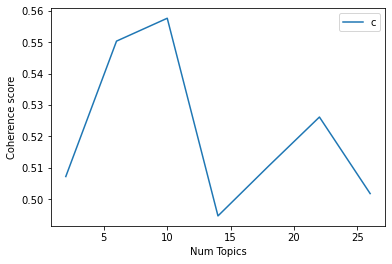

In [36]:
# Show graph
limit=30; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [37]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5072
Num Topics = 6  has Coherence Value of 0.5504
Num Topics = 10  has Coherence Value of 0.5576
Num Topics = 14  has Coherence Value of 0.4947
Num Topics = 18  has Coherence Value of 0.5106
Num Topics = 22  has Coherence Value of 0.5262
Num Topics = 26  has Coherence Value of 0.5018


In [38]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.126*"message" + 0.047*"attachment" + 0.046*"receive" + 0.038*"error" + '
  '0.025*"inquiry" + 0.023*"content" + 0.023*"update" + 0.018*"sender" + '
  '0.017*"transmission" + 0.017*"review"'),
 (1,
  '0.040*"service" + 0.031*"place" + 0.029*"order" + 0.028*"number" + '
  '0.026*"receive" + 0.018*"delivery" + 0.015*"customer" + 0.015*"address" + '
  '0.014*"deliver" + 0.013*"request"'),
 (2,
  '0.051*"email" + 0.032*"invoice" + 0.026*"contact" + 0.026*"receive" + '
  '0.022*"request" + 0.019*"case" + 0.017*"payment" + 0.017*"account" + '
  '0.016*"support" + 0.016*"question"'),
 (3,
  '0.106*"oracle" + 0.039*"marketplace" + 0.033*"submit" + 0.032*"item" + '
  '0.031*"find" + 0.031*"add" + 0.027*"punchout" + 0.026*"cart" + '
  '0.020*"amazon" + 0.019*"time"'),
 (4,
  '0.053*"order" + 0.035*"email" + 0.024*"yield_ods" + '
  '0.024*"length_guaranteed" + 0.024*"address" + 0.024*"product_nmole" + '
  '0.024*"dna_oligo" + 0.024*"item" + 0.023*"purification_standard" + '
  '0.023*"shi

In [39]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


# data should be text_words_no_stops_bigram
# df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=text_words_no_stops_bigarm)
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.2359,"purchase, order, document, attach, purchasing,...","[received, from, good, morning, please, forwar..."
1,1,6.0,0.2628,"purchase, order, document, attach, purchasing,...","[received, from, good, morning, please, forwar..."
2,2,7.0,0.1305,"submit, ucsd, system, procurement, lab, make, ...","[received, from, good, morning, we, received, ..."
3,3,2.0,0.1384,"email, invoice, contact, receive, request, cas...","[will, the, team, please, let, me, know, if, h..."
4,4,4.0,0.3212,"order, email, yield_ods, length_guaranteed, ad...","[received, from, hello, thank, you, for, your,..."
5,5,4.0,0.3104,"order, email, yield_ods, length_guaranteed, ad...","[received, from, hello, thank, you, for, your,..."
6,6,4.0,0.3159,"order, email, yield_ods, length_guaranteed, ad...","[received, from, hello, thank, you, for, your,..."
7,7,4.0,0.3213,"order, email, yield_ods, length_guaranteed, ad...","[received, from, hello, thank, you, for, your,..."
8,8,1.0,0.1672,"service, place, order, number, receive, delive...","[received, from, please, reply, above, this, l..."
9,9,7.0,0.1299,"submit, ucsd, system, procurement, lab, make, ...","[took, the, buying, and, paying, class, but, d..."


In [40]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6353,"message, attachment, receive, error, inquiry, ...","[received, from, thank, you, for, contacting, ..."
1,1.0,0.8533,"service, place, order, number, receive, delive...","[received, from, vitality, medical, prescripti..."
2,2.0,0.6789,"email, invoice, contact, receive, request, cas...","[received, from, hello, how, do, we, fix, this..."
3,3.0,0.6962,"oracle, marketplace, submit, item, find, add, ...","[received, from, hi, my, marketplace, order, i..."
4,4.0,0.9120,"order, email, yield_ods, length_guaranteed, ad...","[received, from, having, trouble, viewing, thi..."
5,5.0,0.5803,"order, requisition, supplier, req, pur, approv...","[received, from, document, requester, change, ..."
6,6.0,0.7006,"purchase, order, document, attach, purchasing,...","[received, from, the, pricing, you, indicate, ..."
7,7.0,0.6766,"submit, ucsd, system, procurement, lab, make, ...","[keep, getting, these, error, messages, and, n..."
8,8.0,0.7164,"information, mail, receive, order, product, em...","[received, from, research, in, non, invasive, ..."
9,9.0,0.4716,"po, order, vendor, number, price, list, receiv...","[received, from, to, university, of, californi..."


In [41]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,6.0,"purchase, order, document, attach, purchasing,...",151.0,0.0505
1.0,6.0,"purchase, order, document, attach, purchasing,...",185.0,0.0619
2.0,7.0,"submit, ucsd, system, procurement, lab, make, ...",232.0,0.0776
3.0,2.0,"email, invoice, contact, receive, request, cas...",653.0,0.2185
4.0,4.0,"order, email, yield_ods, length_guaranteed, ad...",91.0,0.0304
...,...,...,...,...
2984.0,1.0,"service, place, order, number, receive, delive...",NaN,NaN
2985.0,6.0,"purchase, order, document, attach, purchasing,...",NaN,NaN
2986.0,2.0,"email, invoice, contact, receive, request, cas...",NaN,NaN
2987.0,2.0,"email, invoice, contact, receive, request, cas...",NaN,NaN
